Mean Squared Error for sum_avg_cpu: 0.005072429847124342
Accuracy for sum_avg_cpu: 19.35%
Mean Squared Error for sum_avg_memory: 0.0011929592964028553
Accuracy for sum_avg_memory: 29.94%
Mean Squared Error for sum_max_cpu: 0.07890148763912756
Accuracy for sum_max_cpu: 20.76%
Mean Squared Error for sum_max_memory: 0.0015111244651770577
Accuracy for sum_max_memory: 34.08%

Correlation Matrix for Predicted Values:
                sum_avg_cpu  sum_avg_memory  sum_max_cpu  sum_max_memory
sum_avg_cpu        1.000000        0.873171     0.948247        0.884863
sum_avg_memory     0.873171        1.000000     0.884894        0.989517
sum_max_cpu        0.948247        0.884894     1.000000        0.900670
sum_max_memory     0.884863        0.989517     0.900670        1.000000

Scaling Opportunities DataFrame:
     scaling_action          metric
0        Scale Down  sum_max_memory
1        Scale Down     sum_max_cpu
2        Scale Down     sum_max_cpu
3        Scale Down     sum_max_cpu
5     

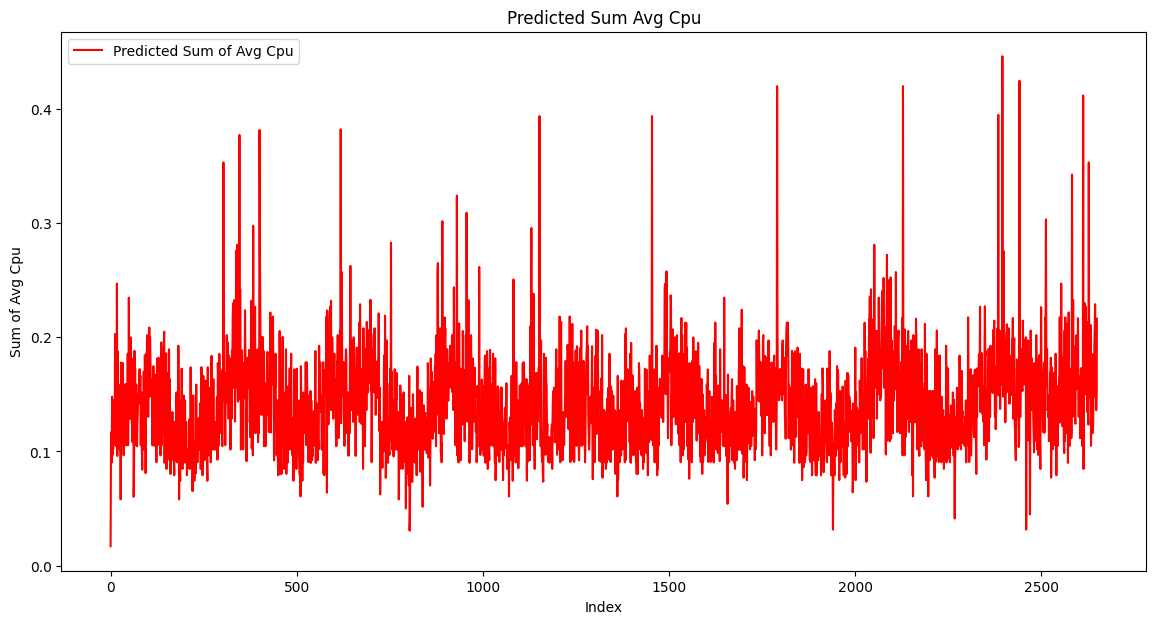

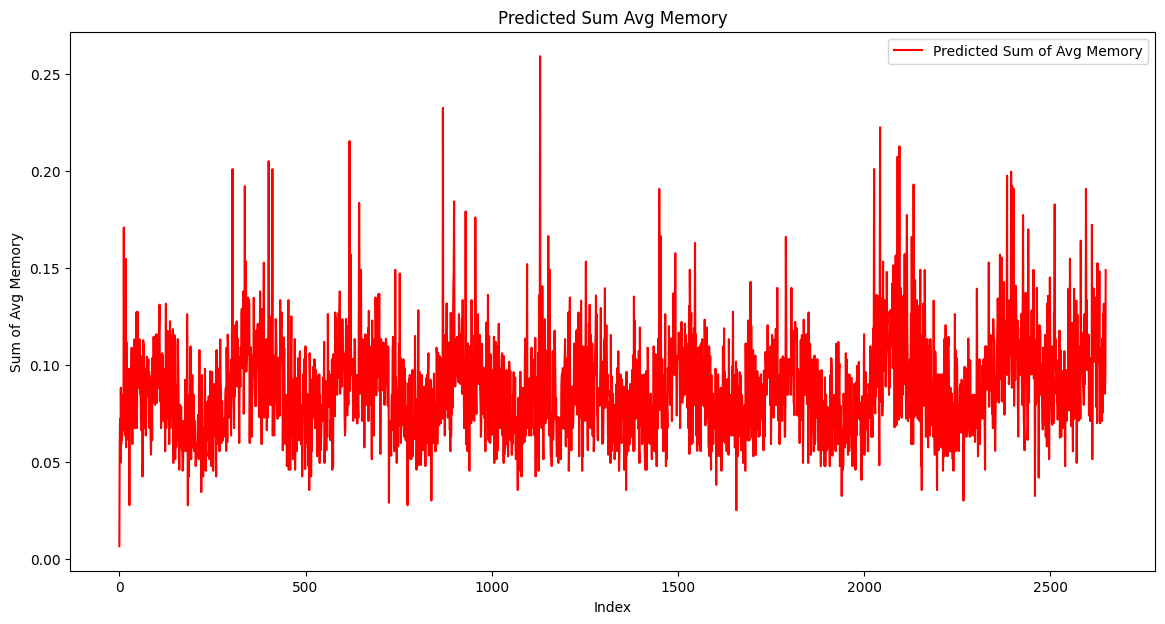

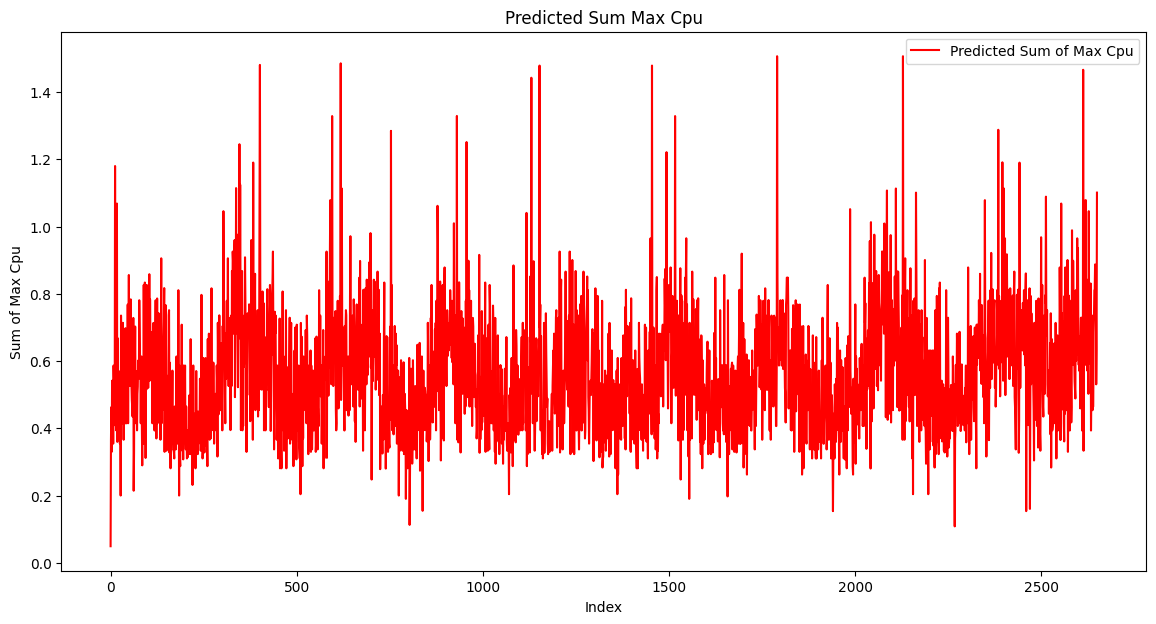

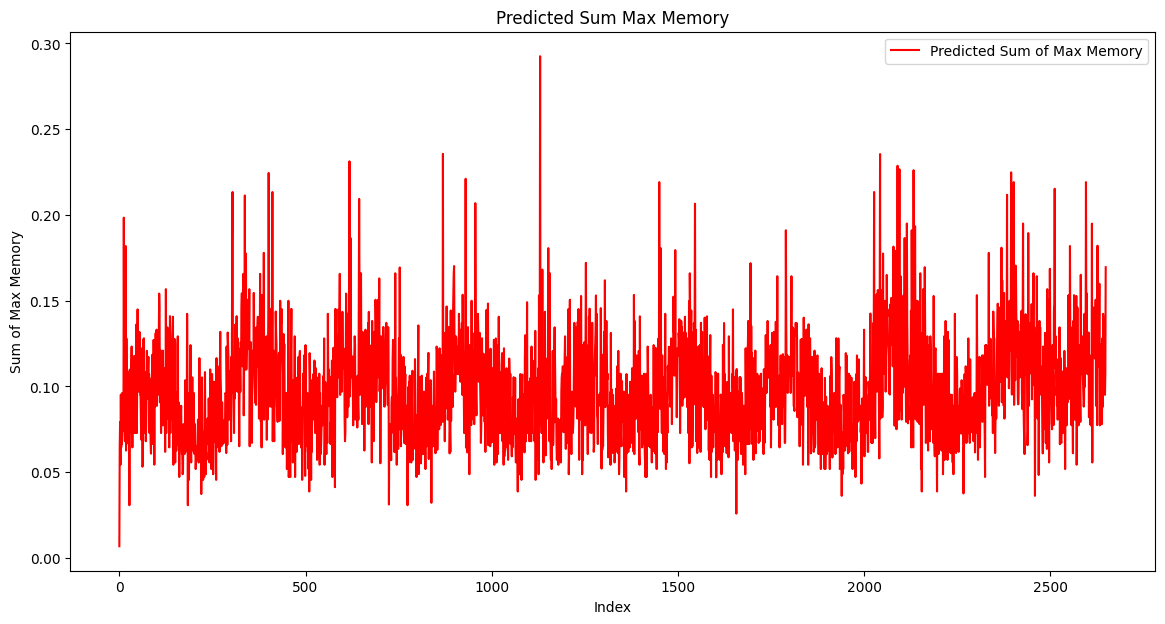

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    # Calculate the count of each collection_id within this interval
    collection_id_counts = interval_data['collection_id'].value_counts()

    # Identify collection_ids that appear more than once (non-unique)
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()

    # Calculate unique collection_id counts
    unique_collection_ids_count = interval_data['collection_id'].nunique()

    # Unique machine_id counts
    unique_machine_ids_count = interval_data['machine_id'].nunique()

    # Usage sums
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()

    return {
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def prepare_features(data):
    results = []
    start_time = data['start_time'].min()
    end_time = data['start_time'].max()

    current_start = start_time

    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = data[(data['start_time'] >= current_start) & (data['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            results.append(interval_result)
        current_start = current_end

    return pd.DataFrame(results)

# Split the data into 70% training and 30% testing
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)


train_features = prepare_features(train_data)


test_features = prepare_features(test_data)


X_train = train_features.drop(columns=['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory'])
y_train = train_features[['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']]

# Initialize XGBoost model
models = {}
for target in y_train.columns:
    models[target] = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    models[target].fit(X_train, y_train[target])


X_test = test_features.drop(columns=['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory'])
y_test = test_features[['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']]


y_pred = pd.DataFrame()
for target in y_test.columns:
    y_pred[target] = models[target].predict(X_test)


for target in y_test.columns:
    mse = mean_squared_error(y_test[target], y_pred[target])
    r2 = r2_score(y_test[target], y_pred[target])
    accuracy_percentage = r2 * 100
    print(f"Mean Squared Error for {target}: {mse}")
    print(f"Accuracy for {target}: {accuracy_percentage:.2f}%")

# Create a DataFrame for predicted values
y_pred_df = y_pred.copy()


prediction_correlation_matrix = y_pred_df.corr()
print("\nCorrelation Matrix for Predicted Values:")
print(prediction_correlation_matrix)

# Define feature-specific scaling thresholds
scaling_thresholds = {
    'sum_avg_cpu': {'scale_up': 0.25, 'scale_down': 0.1},
    'sum_avg_memory': {'scale_up': 0.15, 'scale_down': 0.05},
    'sum_max_cpu': {'scale_up': 1.5, 'scale_down': 0.5},  # Adjusted for range 0-3
    'sum_max_memory': {'scale_up': 0.35, 'scale_down': 0.01}  # Adjusted for range 0-3
}

# Determine scaling opportunities based on correlation and predicted values
scaling_opportunities_df = y_pred_df.copy()
scaling_opportunities_df['scaling_action'] = np.nan
scaling_opportunities_df['metric'] = np.nan

for target in y_pred.columns:
    thresholds = scaling_thresholds[target]
    scale_up_value = thresholds['scale_up']
    scale_down_value = thresholds['scale_down']
    
    # Apply scaling actions based on thresholds
    scaling_opportunities_df.loc[y_pred_df[f'{target}'] >= scale_up_value, 'scaling_action'] = 'Scale Up'
    scaling_opportunities_df.loc[y_pred_df[f'{target}'] <= scale_down_value, 'scaling_action'] = 'Scale Down'
    scaling_opportunities_df.loc[y_pred_df[f'{target}'] >= scale_up_value, 'metric'] = target
    scaling_opportunities_df.loc[y_pred_df[f'{target}'] <= scale_down_value, 'metric'] = target
    
    # Adjust scaling based on correlation
    correlated_metrics = prediction_correlation_matrix[f'{target}'].sort_values(ascending=False).index[1:]  # Exclude self-correlation
    for correlated_metric in correlated_metrics:
        if y_pred_df[f'{target}'].iloc[-1] >= scale_up_value:
            scaling_opportunities_df.loc[y_pred_df[correlated_metric] >= scale_up_value, 'scaling_action'] = 'Scale Up'
        elif y_pred_df[f'{target}'].iloc[-1] <= scale_down_value:
            scaling_opportunities_df.loc[y_pred_df[correlated_metric] <= scale_down_value, 'scaling_action'] = 'Scale Down'

# Display the Scaling Opportunities DataFrame
print("\nScaling Opportunities DataFrame:")
print(scaling_opportunities_df[['scaling_action', 'metric']].dropna())

# Plotting function
def plot_actual_vs_predicted(df, target, ylabel, title):
    plt.figure(figsize=(14, 7))
    sns.lineplot(x=df.index, y=f'{target}', data=df, label=f'Predicted {ylabel}', color='red')
    plt.xlabel('Index')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Predicted values
for target in y_pred.columns:
    plot_actual_vs_predicted(y_pred_df, target, f'Sum of {target.replace("sum_", "").replace("_", " ").title()}', f'Predicted {target.replace("_", " ").title()}')


In [8]:
# Print the first 50 scaling decisions
print(scaling_opportunities_df[['scaling_action', 'metric']].head(50))


   scaling_action          metric
0      Scale Down  sum_max_memory
1      Scale Down     sum_max_cpu
2      Scale Down     sum_max_cpu
3      Scale Down     sum_max_cpu
4             NaN             NaN
5      Scale Down     sum_max_cpu
6      Scale Down     sum_max_cpu
7      Scale Down     sum_max_cpu
8             NaN             NaN
9             NaN             NaN
10            NaN             NaN
11     Scale Down     sum_max_cpu
12       Scale Up  sum_avg_memory
13            NaN             NaN
14     Scale Down     sum_max_cpu
15     Scale Down     sum_max_cpu
16     Scale Down     sum_max_cpu
17       Scale Up  sum_avg_memory
18     Scale Down     sum_max_cpu
19            NaN             NaN
20            NaN             NaN
21            NaN             NaN
22     Scale Down     sum_max_cpu
23     Scale Down     sum_max_cpu
24     Scale Down     sum_max_cpu
25     Scale Down     sum_max_cpu
26            NaN             NaN
27     Scale Down     sum_max_cpu
28            